# Lec 01. logP value prediction from molecular graph with GCN
이번 실습에서는 molecular graph로부터 분자의 특성 중 하나인 logP value를 GCN을 통해 예측해보겠습니다. 이번 실습은 다음과 같은 내용을 포함합니다.

- Custom pytorch dataset을 정의하여 여러 input 또는 여러 output이 존재하는 경우를 다뤄보기
- Graph convolution을 pytorch로 구현하기
- (Gated) skip connection을 pytorch로 구현하기
- 구현된 Graph convolution 적용

## 0. Install Rdkit

분자 데이터셋을 molecular graph 형태로 만들어 주고, 분자의 logP 값을 알려주는 rdkit을 설치합니다.

In [4]:
import sys
import os
import requests
import subprocess
import shutil
from logging import getLogger, StreamHandler, INFO


logger = getLogger(__name__)
logger.addHandler(StreamHandler())
logger.setLevel(INFO)


def install(
        chunk_size=4096,
        file_name="Miniconda3-latest-Linux-x86_64.sh",
        url_base="https://repo.continuum.io/miniconda/",
        conda_path=os.path.expanduser(os.path.join("~", "miniconda")),
        rdkit_version=None,
        add_python_path=True,
        force=False):
    """install rdkit from miniconda
    ```
    import rdkit_installer
    rdkit_installer.install()
    ```
    """

    python_path = os.path.join(
        conda_path,
        "lib",
        "python{0}.{1}".format(*sys.version_info),
        "site-packages",
    )

    if add_python_path and python_path not in sys.path:
        logger.info("add {} to PYTHONPATH".format(python_path))
        sys.path.append(python_path)

    if os.path.isdir(os.path.join(python_path, "rdkit")):
        logger.info("rdkit is already installed")
        if not force:
            return

        logger.info("force re-install")

    url = url_base + file_name
    python_version = "{0}.{1}.{2}".format(*sys.version_info)

    logger.info("python version: {}".format(python_version))

    if os.path.isdir(conda_path):
        logger.warning("remove current miniconda")
        shutil.rmtree(conda_path)
    elif os.path.isfile(conda_path):
        logger.warning("remove {}".format(conda_path))
        os.remove(conda_path)

    logger.info('fetching installer from {}'.format(url))
    res = requests.get(url, stream=True)
    res.raise_for_status()
    with open(file_name, 'wb') as f:
        for chunk in res.iter_content(chunk_size):
            f.write(chunk)
    logger.info('done')

    logger.info('installing miniconda to {}'.format(conda_path))
    subprocess.check_call(["bash", file_name, "-b", "-p", conda_path])
    logger.info('done')

    logger.info("installing rdkit")
    subprocess.check_call([
        os.path.join(conda_path, "bin", "conda"),
        "install",
        "--yes",
        "-c", "rdkit",
        "python=={}".format(python_version),
        "rdkit" if rdkit_version is None else "rdkit=={}".format(rdkit_version)])
    logger.info("done")

    import rdkit
    logger.info("rdkit-{} installation finished!".format(rdkit.__version__))


if __name__ == "__main__":
    install()

add /root/miniconda/lib/python3.6/site-packages to PYTHONPATH
python version: 3.6.9
fetching installer from https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
done
installing miniconda to /root/miniconda
done
installing rdkit
done
rdkit-2020.03.3 installation finished!


분자를 텍스트 형태로 표현한 smiles 파일과 molecular graph를 생성하는데 필요한 vocab.npy 파일을 받습니다.

In [1]:
!curl -o ZINC.smiles https://raw.githubusercontent.com/heartcored98/Standalone-DeepLearning/master/Lec9/ZINC.smiles
!curl -o vocab.npy https://raw.githubusercontent.com/heartcored98/Standalone-DeepLearning/master/Lec9/vocab.npy

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 5374k  100 5374k    0     0  6578k      0 --:--:-- --:--:-- --:--:-- 6570k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   256  100   256    0     0    688      0 --:--:-- --:--:-- --:--:--   688


## 1. Pre-Processing

ZINC.smiles 파일에 text로 표현되어 있는 분자들을 molecular graph 형태로 바꿔줍시다. 이때 node feature matrix는 아래 그림과 같이 각 원자의 symbol, degree 등 화학적 특성을 one-hot vector로 나타낸 형태입니다.
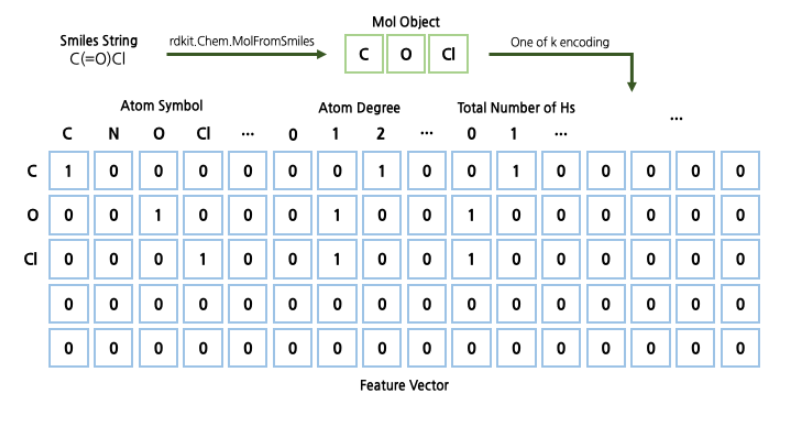



In [3]:
!pip install rdkit

ERROR: Could not find a version that satisfies the requirement rdkit (from versions: none)
ERROR: No matching distribution found for rdkit


In [5]:
from tqdm import tnrange, tqdm_notebook
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem.Crippen import MolLogP
import numpy as np

def read_ZINC_smiles(file_name, num_mol):
    f = open(file_name, 'r')
    contents = f.readlines()

    smi_list = []
    logP_list = []

    for i in tqdm_notebook(range(num_mol), desc='Reading Data'):
        smi = contents[i].strip()
        m = Chem.MolFromSmiles(smi)
        smi_list.append(smi)
        logP_list.append(MolLogP(m))

    logP_list = np.asarray(logP_list).astype(float)

    return smi_list, logP_list


def smiles_to_onehot(smi_list):
    def smiles_to_vector(smiles, vocab, max_length):
        while len(smiles) < max_length:
            smiles += " "
        vector = [vocab.index(str(x)) for x in smiles]
        one_hot = np.zeros((len(vocab), max_length), dtype=int)
        for i, elm in enumerate(vector):
            one_hot[elm][i] = 1
        return one_hot

    vocab = np.load('./vocab.npy')
    smi_total = []

    for i, smi in tqdm_notebook(enumerate(smi_list), desc='Converting to One Hot'):
        smi_onehot = smiles_to_vector(smi, list(vocab), 120)
        smi_total.append(smi_onehot)

    return np.asarray(smi_total)

def convert_to_graph(smiles_list):
    adj = []
    adj_norm = []
    features = []
    maxNumAtoms = 50
    for i in tqdm_notebook(smiles_list, desc='Converting to Graph'):
        # Mol
        iMol = Chem.MolFromSmiles(i.strip())
        #Adj
        iAdjTmp = Chem.rdmolops.GetAdjacencyMatrix(iMol)
        # Feature
        if( iAdjTmp.shape[0] <= maxNumAtoms):
            # Feature-preprocessing
            iFeature = np.zeros((maxNumAtoms, 58))
            iFeatureTmp = []
            for atom in iMol.GetAtoms():
                iFeatureTmp.append( atom_feature(atom) ) ### atom features only
            iFeature[0:len(iFeatureTmp), 0:58] = iFeatureTmp ### 0 padding for feature-set
            features.append(iFeature)

            # Adj-preprocessing
            iAdj = np.zeros((maxNumAtoms, maxNumAtoms))
            iAdj[0:len(iFeatureTmp), 0:len(iFeatureTmp)] = iAdjTmp + np.eye(len(iFeatureTmp))
            adj.append(np.asarray(iAdj))
    features = np.asarray(features)

    return features, adj
    
def atom_feature(atom):
    return np.array(one_of_k_encoding_unk(atom.GetSymbol(),
                                      ['C', 'N', 'O', 'S', 'F', 'H', 'Si', 'P', 'Cl', 'Br',
                                       'Li', 'Na', 'K', 'Mg', 'Ca', 'Fe', 'As', 'Al', 'I', 'B',
                                       'V', 'Tl', 'Sb', 'Sn', 'Ag', 'Pd', 'Co', 'Se', 'Ti', 'Zn',
                                       'Ge', 'Cu', 'Au', 'Ni', 'Cd', 'Mn', 'Cr', 'Pt', 'Hg', 'Pb']) +
                    one_of_k_encoding(atom.GetDegree(), [0, 1, 2, 3, 4, 5]) +
                    one_of_k_encoding_unk(atom.GetTotalNumHs(), [0, 1, 2, 3, 4]) +
                    one_of_k_encoding_unk(atom.GetImplicitValence(), [0, 1, 2, 3, 4, 5]) +
                    [atom.GetIsAromatic()])    # (40, 6, 5, 6, 1)

def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise Exception("input {0} not in allowable set{1}:".format(x, allowable_set))
    return list(map(lambda s: x == s, allowable_set))

def one_of_k_encoding_unk(x, allowable_set):
    """Maps inputs not in the allowable set to the last element."""
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))

In [6]:
from tqdm import tnrange, tqdm_notebook
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem.Crippen import MolLogP
import numpy as np

def read_ZINC_smiles(file_name, num_mol):
    f = open(file_name, 'r')
    contents = f.readlines()

    smi_list = []
    logP_list = []

    for i in tqdm_notebook(range(num_mol), desc='Reading Data'):
        smi = contents[i].strip()
        m = Chem.MolFromSmiles(smi)
        smi_list.append(smi)
        logP_list.append(MolLogP(m))

    logP_list = np.asarray(logP_list).astype(float)

    return smi_list, logP_list


def smiles_to_onehot(smi_list):
    def smiles_to_vector(smiles, vocab, max_length):
        while len(smiles) < max_length:
            smiles += " "
        vector = [vocab.index(str(x)) for x in smiles]
        one_hot = np.zeros((len(vocab), max_length), dtype=int)
        for i, elm in enumerate(vector):
            one_hot[elm][i] = 1
        return one_hot

    vocab = np.load('./vocab.npy')
    smi_total = []

    for i, smi in tqdm_notebook(enumerate(smi_list), desc='Converting to One Hot'):
        smi_onehot = smiles_to_vector(smi, list(vocab), 120)
        smi_total.append(smi_onehot)

    return np.asarray(smi_total)

def convert_to_graph(smiles_list):
    adj = []
    adj_norm = []
    features = []
    maxNumAtoms = 50
    for i in tqdm_notebook(smiles_list, desc='Converting to Graph'):
        # Mol
        iMol = Chem.MolFromSmiles(i.strip())
        #Adj
        iAdjTmp = Chem.rdmolops.GetAdjacencyMatrix(iMol)
        # Feature
        if( iAdjTmp.shape[0] <= maxNumAtoms):
            # Feature-preprocessing
            iFeature = np.zeros((maxNumAtoms, 58))
            iFeatureTmp = []
            for atom in iMol.GetAtoms():
                iFeatureTmp.append( atom_feature(atom) ) ### atom features only
            iFeature[0:len(iFeatureTmp), 0:58] = iFeatureTmp ### 0 padding for feature-set
            features.append(iFeature)

            # Adj-preprocessing
            iAdj = np.zeros((maxNumAtoms, maxNumAtoms))
            iAdj[0:len(iFeatureTmp), 0:len(iFeatureTmp)] = iAdjTmp + np.eye(len(iFeatureTmp))
            adj.append(np.asarray(iAdj))
    features = np.asarray(features)

    return features, adj
    
def atom_feature(atom):
    return np.array(one_of_k_encoding_unk(atom.GetSymbol(),
                                      ['C', 'N', 'O', 'S', 'F', 'H', 'Si', 'P', 'Cl', 'Br',
                                       'Li', 'Na', 'K', 'Mg', 'Ca', 'Fe', 'As', 'Al', 'I', 'B',
                                       'V', 'Tl', 'Sb', 'Sn', 'Ag', 'Pd', 'Co', 'Se', 'Ti', 'Zn',
                                       'Ge', 'Cu', 'Au', 'Ni', 'Cd', 'Mn', 'Cr', 'Pt', 'Hg', 'Pb']) +
                    one_of_k_encoding(atom.GetDegree(), [0, 1, 2, 3, 4, 5]) +
                    one_of_k_encoding_unk(atom.GetTotalNumHs(), [0, 1, 2, 3, 4]) +
                    one_of_k_encoding_unk(atom.GetImplicitValence(), [0, 1, 2, 3, 4, 5]) +
                    [atom.GetIsAromatic()])    # (40, 6, 5, 6, 1)

def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise Exception("input {0} not in allowable set{1}:".format(x, allowable_set))
    return list(map(lambda s: x == s, allowable_set))

def one_of_k_encoding_unk(x, allowable_set):
    """Maps inputs not in the allowable set to the last element."""
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))

위 코드를 통해 원하는 수 만큼의 분자들의 node feature matrix list인 `list_feature`, adjacency matrix list인 `list_adj`, 그리고 logP value list인 `list_logP`를 얻었습니다.

그 동안의 실습에서는 이미지로부터 이미지의 label을 얻는, 즉 하나의 input에서 하나의 output을 얻는 형태였지만, 이번 실습에서는 두 개의 input, `list_feature`와 `list_adj`로부터 logP value라는 하나의 output을 얻어내야합니다. 이를 위해 custom pytorch dataset을 정의하고 사용해봅시다.

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader

class GCNDataset(Dataset):
    def __init__(self, list_feature, list_adj, list_logP):
        self.list_feature = list_feature
        self.list_adj = list_adj
        self.list_logP = list_logP

    def __len__(self):
        return len(self.list_feature)

    def __getitem__(self, index):
        return self.list_feature[index], self.list_adj[index], self.list_logP[index]


def partition(list_feature, list_adj, list_logP, args):
    num_total = list_feature.shape[0]
    num_train = int(num_total * (1 - args.test_size - args.val_size))
    num_val = int(num_total * args.val_size)
    num_test = int(num_total * args.test_size)

    feature_train = list_feature[:num_train]
    adj_train = list_adj[:num_train]
    logP_train = list_logP[:num_train]

    feature_val = list_feature[num_train:num_train + num_val]
    adj_val = list_adj[num_train:num_train + num_val]
    logP_val = list_logP[num_train:num_train + num_val]
    
    feature_test = list_feature[num_total - num_test:]
    adj_test = list_adj[num_total - num_test:]
    logP_test = list_logP[num_total - num_test:]
        
    train_set = GCNDataset(feature_train, adj_train, logP_train)
    val_set = GCNDataset(feature_val, adj_val, logP_val)
    test_set = GCNDataset(feature_test, adj_test, logP_test)

    partition = {
        'train': train_set,
        'val': val_set,
        'test': test_set
    }

    return partition

# 2. Model Construction

Graph Convolution Network, 즉 GCN을 pytorch를 이용하여 구현하여봅시다. 이를 위해 다음과 같은 sub module들을 구현하고 사용합니다.

- **GCNLayer**: node feature matrix와 adjacency matrix의 list를 받아 graph convolution 연산을 수행하는 module 입니다.
- **(Gated)SkipConnection**: ResNet에서 사용되었던 skip connection technique을 구현한 module 입니다.
- **GCNBlock**: node feature matrix와 adjacency matrix의 list를 받아 원하는 갯수의 GCNLayer를 통과시킨 후, (gated)skip connection을 적용하는 module 입니다.
- **ReadOut**: graph structrure에 permutation invariance를 주기 위하여 linear layer를 거친 뒤 batch 별로 summation하는 module 입니다.
- **Predictor**: ReadOut layer로부터의 graph feature vector로부터 logP value를 예측하기 위한 linear layer module 입니다.

위 모듈들을 사용하여 **GCNNet**을 구현해봅시다.

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

In [9]:
class GCNLayer(nn.Module):
    
    def __init__(self, in_dim, out_dim, n_atom, act=None, bn=False):
        super(GCNLayer, self).__init__()
        
        self.use_bn = bn
        self.linear = nn.Linear(in_dim, out_dim)
        nn.init.xavier_uniform_(self.linear.weight) 
        self.bn = nn.BatchNorm1d(n_atom)
        self.activation = act
        
    def forward(self, x, adj):
        out = self.linear(x)
        out = torch.matmul(adj, out) 
        if self.use_bn:
            out = self.bn(out)
        if self.activation != None:
            out = self.activation(out)
        return out, adj

In [10]:
class SkipConnection(nn.Module):
    
    def __init__(self, in_dim, out_dim):
        super(SkipConnection, self).__init__()
        
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.linear = nn.Linear(in_dim, out_dim, bias=False)
        
    def forward(self, in_x, out_x):
        if (self.in_dim != self.out_dim):
            in_x = self.linear(in_x)
        out = in_x + out_x
        return out

In [11]:
class GCNBlock(nn.Module):
    
    def __init__(self, n_layer, in_dim, hidden_dim, out_dim, n_atom, bn=True, sc='gsc'):
        super(GCNBlock, self).__init__()
        
        self.layers = nn.ModuleList()
        for i in range(n_layer):
            self.layers.append(GCNLayer(in_dim if i==0 else hidden_dim,
                                        out_dim if i==n_layer-1 else hidden_dim,
                                        n_atom,
                                        nn.ReLU() if i!=n_layer-1 else None,
                                        bn))
        self.relu = nn.ReLU()
        if sc=='gsc':
            self.sc = GatedSkipConnection(in_dim, out_dim)
        elif sc=='sc':
            self.sc = SkipConnection(in_dim, out_dim)
        elif sc=='no':
            self.sc = None
        else:
            assert False, "Wrong sc type."
        
    def forward(self, x, adj):
        residual = x
        for i, layer in enumerate(self.layers):
            out, adj = layer((x if i==0 else out), adj)
        if self.sc != None:
            out = self.sc(residual, out)
        out = self.relu(out)
        return out, adj

In [12]:
class ReadOut(nn.Module):
    
    def __init__(self, in_dim, out_dim, act=None):
        super(ReadOut, self).__init__()
        
        self.in_dim = in_dim
        self.out_dim= out_dim
        
        self.linear = nn.Linear(self.in_dim, 
                                self.out_dim)
        nn.init.xavier_uniform_(self.linear.weight)
        self.activation = act

    def forward(self, x):
        out = self.linear(x)
        out = torch.sum(out, 1)
        if self.activation != None:
            out = self.activation(out)
        return out

In [13]:
class Predictor(nn.Module):
    
    def __init__(self, in_dim, out_dim, act=None):
        super(Predictor, self).__init__()
        
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.linear = nn.Linear(self.in_dim,
                                self.out_dim)
        nn.init.xavier_uniform_(self.linear.weight)
        self.activation = act
        
    def forward(self, x):
        out = self.linear(x)
        if self.activation != None:
            out = self.activation(out)
        return out

In [16]:
class GCNNet(nn.Module):
    
    def __init__(self, args):
        super(GCNNet, self).__init__()
        
        self.blocks = nn.ModuleList()
        for i in range(args.n_block):
            self.blocks.append(GCNBlock(args.n_layer,
                                        args.in_dim if i==0 else args.hidden_dim,
                                        args.hidden_dim,
                                        args.hidden_dim,
                                        args.n_atom,
                                        args.bn,
                                        args.sc))
        self.readout = ReadOut(in_dim = args.hidden_dim,
                               out_dim = args.pred_dim1) # input: hiddend_dim / output: pred_dim1
        self.pred1 = Predictor(in_dim = args.pred_dim1,
                               out_dim = args.pred_dim2,
                               act = 'relu')
        self.pred2 = Predictor(in_dim = args.pred_dim2,
                               out_dim = args.pred_dim3,
                               act = 'relu')
        self.pred3 = Predictor(in_dim = args.pred_dim3,
                               out_dim = args.output_dim,
                               act = 'relu')
        
    def forward(self, x, adj):
        for i, block in enumerate(self.blocks):
            out, adj = block((x if i==0 else out), adj)
        out = self.readout(out)
        out = self.pred1(out)
        out = self.pred2(out)
        out = self.pred3(out)
        return out

# 3. Train, Validate, Test and Experiment

In [17]:
import argparse
import sys
import time
import copy

from sklearn.metrics import mean_absolute_error

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


- 파라미터 셋팅

In [ ]:
paser = argparse.ArgumentParser()
args = paser.parse_args("")

args.seed = 123
args.val_size = 0.1
args.test_size = 0.1
args.shuffle = True
args.device = 'cuda'

args.n_block = 1 # 1~4
args.n_layer = 4 # 1~4
args.in_dim = 58
args.hidden_dim = 128
args.n_atom = 50
args.bn = True
args.sc = 'sc'

args.pred_dim1 = 64
args.pred_dim2 = 32
args.pred_dim3 = 16
args.out_dim = 1

args.batch_size = 32
args.epochs = 100
args.print_every = 10
args.lr = 0.001
args.l2 = 0.001
args.optim = 'Adam' # Adam, SGD, RMSprop


#set seed
torch.manual_seed(args.seed)
np.random.seed(args.seed)

device = torch.device(args.device)

- 데이터/모델 셋팅

In [ ]:
#load data
time1 = time.time()
print("load data... ")

## 1. preprocessing의 convert_to_graph 함수, read_ZINC_smiles: num_mol 10000개로 설정해서 사용
list_smi, list_logP = read_ZINC_smiles('ZINC.smiles', num_mol= 10000)
list_feature, list_adj = 

## 1.preprocessing의 partition함수, 파이토치 DataLoader 이용하기
dict_partition = partition(list_feature, list_adj, list_logP, args)
## 
train_loader = torch.utils.data.DataLoader(dict_partition[# train], 
                                          batch_size = args.batch_size, 
                                          shuffle = )
val_loader = 
test_loader = 

## GCNNet 이용
model = # 지정한모델함수(args)
model.to(device)

## loss 지정
criterion = nn.MSELoss()

## optimizer 지정 
if args.optim == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=args.lr, weight_decay=args.l2)
elif args.optim == 'RMSprop':
    
elif args.optim == 'Adam':
    
else:
    raise ValueError('In-valid optimizer choice')



In [ ]:
print("start training...",flush=True)
val_time = []
train_time = []
train_loss = []
valid_loss = []
for i in range(1,args.epochs+1):      
    t_l = 0.0
    t1 = time.time()
    for iter, data in enumerate(train_loader):

        model.train()
        optimizer.zero_grad()
        # 데이터 불러오기
        
        ## train_loader의 data 이용 3개의 변수 생성
        a, b, c = 
        
        ##  텐서화
        train_x = 
        train_adj = 
        trainy = torch.Tensor(c.float()).to(device)
        trainy = trainy.view(-1, 1)
        
        # 트레이닝
        outputs = model( )
        
        # 로스 계산
        loss = criterion(  )
        loss.backward()
        optimizer.step()
        t_l += loss.item()
        if iter % args.print_every == 0 :
            log = 'Iter: {:03d}, Train Loss: {:.4f}'
            print(log.format(iter, t_l,flush=True))

    t2 = time.time()
    train_time.append(t2-t1)
    
    #validation
    v_l = 0.0
    s1 = time.time()
    for iter, data in enumerate(val_loader):
        model.eval()
        ## train_loader의 data 이용 3개의 변수 생성
        a, b, c = 
        
        ##  텐서화
        val_x =
        val_adj = 
        val_y = torch.Tensor(c.float()).to(device)
        val_y = val_y.view(-1, 1)
        
        outputs = model()
        
        loss = criterion()

        v_l += loss.item()
        
    s2 = time.time()
    log = 'Epoch: {:03d}, Inference Time: {:.4f} secs'
    print(log.format(i,(s2-s1)))
    val_time.append(s2-s1)
    train_loss.append(t_l)
    valid_loss.append(v_l)
    log = 'Epoch: {:03d}, Train Loss: {:.4f}, Valid Loss: {:.4f}, Training Time: {:.4f}/epoch'
    print(log.format(i, t_l, v_l, (t2 - t1)),flush=True)
  
print("Average Training Time: {:.4f} secs/epoch".format(np.mean(train_time)))
print("Average Inference Time: {:.4f} secs".format(np.mean(val_time)))
print("Training finished")
print("Training time spent: {:.4f}".format(t2 - t1))


SyntaxError: ignored

In [ ]:

#testing
logP_total = list()
pred_logP_total = list()
for iter, data in enumerate(test_loader):
    model.eval()
    a, b, c


    test_x = 
    test_adj =
    test_y = 
    logP_total += test_y.tolist()
    
    # 테스트
    with torch.no_grad():
      outputs = model()
      pred_logP_total += outputs.view(-1).tolist()

mae = mean_absolute_error(logP_total, pred_logP_total)
std = np.std(np.array(logP_total)-np.array(pred_logP_total))  
print("Testing time spent: {:.4f}".format(t2 - t1))
log = 'Evaluate model on test data, Test MAE: {:.4f}, Test std: {:.4f}'
print(log.format(mae, std))

time2 = time.time()
print("Total time spent: {:.4f}".format(time2-time1))

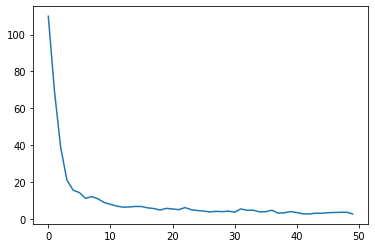

In [ ]:
from matplotlib import pyplot as plt
# train_loss 시각화

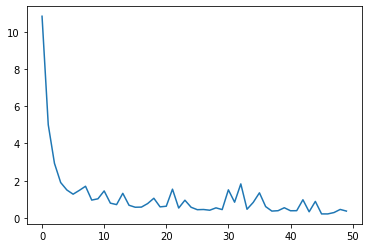

In [ ]:
from matplotlib import pyplot as plt
# valid_loss 시각화